<a href="https://colab.research.google.com/github/nimran79/Spark-recommender/blob/main/music_recommendation_system_with_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize Google colab

In [3]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = "/content/drive/My Drive/Colab Notebooks/Dataset"
os.chdir(path)
!ls

data_by_artist.csv  data_by_year.csv  data_w_genres.csv
data_by_genres.csv  data.csv


Install PySpark and JVM

In [5]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 40 kB/s 
     |████████████████████████████████| 199 kB 48.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=c1630f88520df5029aa51148e27af3b988442a65076cb0a8c5ac759f1c2b399d
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


# Create a Spark Session

In [6]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local[2]")\
        .appName("Music recommendation")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [53]:
# get spark context
sc = spark.sparkContext

In [8]:
spark

# Import Libraries

In [38]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.ml.feature import OneHotEncoder, StringIndexer, StandardScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import rand, col, udf, lit
from pyspark.mllib.evaluation import MulticlassMetrics

In [10]:
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Load Data

In [11]:
data = spark.read.csv('data.csv',inferSchema=True, header =True)
genre_data = spark.read.csv('data_by_genres.csv',inferSchema=True, header =True)
year_data = spark.read.csv('data_by_year.csv',inferSchema=True, header =True)

### Inspect the Data

In [11]:
# description of data 
data.summary().show()

+-------+-------------------+------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+------------------+------------------+----------------------+------------------+--------------------+--------------------+--------------------+
|summary|            valence|              year|       acousticness|             artists|        danceability|         duration_ms|              energy|            explicit|                  id|    instrumentalness|               key|            liveness|          loudness|              mode|                  name|        popularity|        release_date|         speechiness|               tempo|
+-------+-------------------+------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------

In [12]:
# Features
data.printSchema()

root
 |-- valence: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- artists: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- explicit: string (nullable = true)
 |-- id: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- key: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- tempo: string (nullable = true)



In [47]:
# Convert some columns to int or double
df = data.withColumn("danceability",data.danceability.cast('double'))
df = df.withColumn("duration_ms",data.duration_ms.cast('double'))
df = df.withColumn("energy",data.energy.cast('double'))
df = df.withColumn("explicit",data.explicit.cast('int'))
df = df.withColumn("instrumentalness",data.instrumentalness.cast('double'))
df = df.withColumn("key",data.key.cast('int'))
df = df.withColumn("liveness",data.liveness.cast('double'))
df = df.withColumn("loudness",data.loudness.cast('double'))
df = df.withColumn("mode",data.mode.cast('int'))
df = df.withColumn("popularity",data.popularity.cast('int'))
df = df.withColumn("speechiness",data.speechiness.cast('double'))
df = df.withColumn("tempo",data.tempo.cast('double'))

In [48]:
df.printSchema()

root
 |-- valence: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- artists: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- explicit: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- release_date: string (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- tempo: double (nullable = true)



In [28]:
# Look at first 3 rows
df.show(3)

+-------+----+------------+--------------------+------------------+-----------+------+--------+--------------------+----------------+---+--------+--------+----+--------------------+----------+------------+-----------+-----------------+
|valence|year|acousticness|             artists|      danceability|duration_ms|energy|explicit|                  id|instrumentalness|key|liveness|loudness|mode|                name|popularity|release_date|speechiness|            tempo|
+-------+----+------------+--------------------+------------------+-----------+------+--------+--------------------+----------------+---+--------+--------+----+--------------------+----------+------------+-----------+-----------------+
| 0.0594|1921|       0.982|['Sergei Rachmani...|             0.279|   831667.0| 0.211|       0|4BJqT0PrAfrxzMOxy...|           0.878| 10|   0.665| -20.096|   1|Piano Concerto No...|         4|        1921|     0.0366|           80.954|
|  0.963|1921|       0.732|      ['Dennis Day']|0.819000

In [16]:
# Look at first 3 rows
genre_data.show(3)

+----+--------------------+------------------+-------------------+------------------+-------------------+------------------+--------+-------------------+-------------------+------------------+-------------------+-----------------+---+
|mode|              genres|      acousticness|       danceability|       duration_ms|             energy|  instrumentalness|liveness|           loudness|        speechiness|             tempo|            valence|       popularity|key|
+----+--------------------+------------------+-------------------+------------------+-------------------+------------------+--------+-------------------+-------------------+------------------+-------------------+-----------------+---+
|   1|21st century clas...|0.9793333333333332|0.16288333333333335|160297.66666666663|0.07131666666666665|        0.60683367|  0.3616|-31.514333333333337|0.04056666666666667|           75.3365|0.10378333333333334|27.83333333333333|  6|
|   1|               432hz|           0.49478| 0.29933333333

In [17]:
# Look at first 3 rows
year_data.show(3)

+----+----+------------------+------------------+------------------+-------------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+---+
|mode|year|      acousticness|      danceability|       duration_ms|             energy|   instrumentalness|          liveness|           loudness|       speechiness|             tempo|            valence|         popularity|key|
+----+----+------------------+------------------+------------------+-------------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+---+
|   1|1921|0.8868960000000005|0.4185973333333336|260537.16666666663|0.23181513333333334|0.34487805886666656|           0.20571| -17.04866666666665|          0.073662|101.53149333333329|0.37932666666666665| 0.6533333333333333|  2|
|   1|1922|0.9385915492957748|0.4820422535211267|165469.74647887325|0.2378153521

# Exploratory Data Analysis

### Correlation Matrix

We are going to check the correlation between different features.

In [127]:
# dropping string columns for calculating correlation
df2 = df.drop("artists","id","name","release_date")
df2.printSchema()

root
 |-- valence: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- explicit: integer (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- liveness: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- tempo: double (nullable = true)



In [128]:
df2.show(3)

+-------+----+------------+------------------+-----------+------+--------+----------------+---+--------+--------+----+----------+-----------+-----------------+
|valence|year|acousticness|      danceability|duration_ms|energy|explicit|instrumentalness|key|liveness|loudness|mode|popularity|speechiness|            tempo|
+-------+----+------------+------------------+-----------+------+--------+----------------+---+--------+--------+----+----------+-----------+-----------------+
| 0.0594|1921|       0.982|             0.279|   831667.0| 0.211|       0|           0.878| 10|   0.665| -20.096|   1|         4|     0.0366|           80.954|
|  0.963|1921|       0.732|0.8190000000000001|   180533.0| 0.341|       0|             0.0|  7|    0.16| -12.441|   1|         5|      0.415|60.93600000000001|
| 0.0394|1921|       0.961|             0.328|   500062.0| 0.166|       0|           0.913|  3|   0.101|  -14.85|   1|         5|     0.0339|          110.339|
+-------+----+------------+-------------

In [129]:
assembler =  VectorAssembler(inputCols=df2.columns, outputCol= "corr-features")

In [130]:
#df2_vector = assembler.transform(df2).select("corr-features")
df2_vector = assembler.setHandleInvalid("skip").transform(df2).select("corr-features")

In [ ]:
df2_vector.select("corr-features").show(truncate=False)

In [133]:
pearsonCorr = Correlation.corr(df2_vector, "corr-features").collect()[0][0]
corr_matrix = pearsonCorr.toArray().tolist()
#print(corr_matrix)

[[1.0, -0.03541654944128016, -0.17672976884999778, 0.5546943914354214, -0.191693718249267, 0.3483644596884207, -0.021159774979756026, -0.19935338829441576, 0.028294021941997483, 0.0046212639000724675, 0.3082344520413005, 0.015989306551325307, 0.005276649891261011, 0.04489805716384784, 0.1689615119878607], [-0.03541654944128016, 1.0, -0.6124592072403682, 0.1836196630178344, 0.08137051736397563, 0.5285137440708516, 0.21975886662852212, -0.2747450488487442, 0.006975811893526693, -0.05633955343518271, 0.48711215118267387, -0.03225146873188148, 0.8617760694827559, -0.1695598097941896, 0.13887194185254645], [-0.17672976884999778, -0.6124592072403682, 1.0, -0.26054899778124946, -0.07831172959283116, -0.7478802615746392, -0.24487490502945003, 0.3322663880518377, -0.020058439164729373, -0.02601189453536344, -0.5598325569083672, 0.046986045606242914, -0.570049633753811, -0.04322806705679614, -0.20511348642253824], [0.5546943914354214, 0.1836196630178344, -0.26054899778124946, 1.0, -0.13874281216

In [134]:
df2_corr = spark.createDataFrame(corr_matrix, df2.columns)
df2_corr.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|             valence|                year|        acousticness|        danceability|         duration_ms|              energy|            explicit|    instrumentalness|                 key|            liveness|            loudness|                mode|          popularity|         speechiness|               tempo|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 1.0|-0.03541654944128016|-0.176

### Heat Map

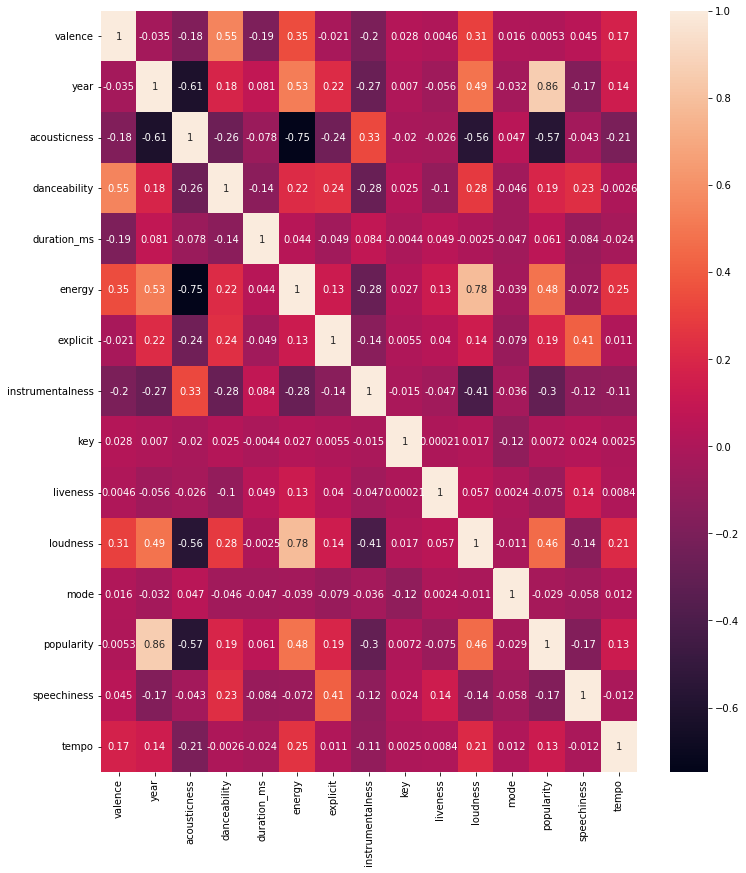

In [138]:
#specify size of heatmap
fig, ax = plt.subplots(figsize=(12, 14))
sns.heatmap(corr_matrix, xticklabels=df2_corr.columns, yticklabels=df2_corr.columns, annot=True) 

### Music by Year

In [50]:
def get_decade(year):
    period_start = int(year/10) * 10
    decade = '{}s'.format(period_start)
    return decade

In [73]:
decadeUDF = udf(lambda z:get_decade(z))   
df_temp = df.withColumn("decade", decadeUDF(col("year")))

In [74]:
df_temp.show(3)

+-------+----+------------+--------------------+------------------+-----------+------+--------+--------------------+----------------+---+--------+--------+----+--------------------+----------+------------+-----------+-----------------+------+
|valence|year|acousticness|             artists|      danceability|duration_ms|energy|explicit|                  id|instrumentalness|key|liveness|loudness|mode|                name|popularity|release_date|speechiness|            tempo|decade|
+-------+----+------------+--------------------+------------------+-----------+------+--------+--------------------+----------------+---+--------+--------+----+--------------------+----------+------------+-----------+-----------------+------+
| 0.0594|1921|       0.982|['Sergei Rachmani...|             0.279|   831667.0| 0.211|       0|4BJqT0PrAfrxzMOxy...|           0.878| 10|   0.665| -20.096|   1|Piano Concerto No...|         4|        1921|     0.0366|           80.954| 1920s|
|  0.963|1921|       0.732| 

In [78]:
# convert to pandas dataframe for plotting
pandasDF = df_temp.toPandas()
pandasDF2 = year_data.toPandas()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


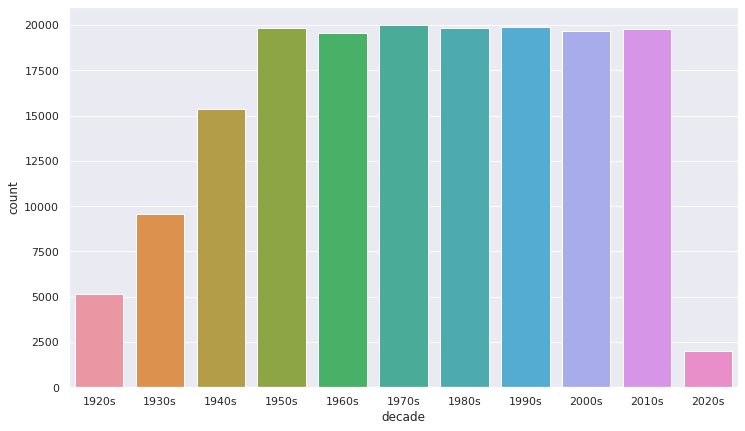

In [72]:
sns.set(rc={'figure.figsize':(12 ,7)})
sns.countplot(pandasDF["decade"])

### Music by various sound properties

In [77]:
import plotly.express as px 

pyspark.sql.dataframe.DataFrame

In [82]:
sound_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'valence']
fig = px.line(pandasDF2, x='year', y=sound_features)
fig.show()

# Recommendation System